### Train a VLM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoVLM'):
    !git clone https://github.com/huggingface/nanoVLM.git
%cd nanoVLM/
!ls

Cloning into 'nanoVLM'...
remote: Enumerating objects: 743, done.
remote: Counting objects: 100% (489/489), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 743 (delta 408), reused 329 (delta 318), pack-reused 254 (from 1)
Receiving objects: 100% (743/743), 13.25 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (485/485), done.
/content/nanoVLM
assets			data		 models		tests
benchmark-inference.py	generate.py	 nanoVLM.ipynb	train.py
benchmark_suite.py	measure_vram.py  README.md


### Imports and Setup

In [2]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install datasets==3.5.0
!pip -q install tqdm
!pip -q install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not

In [3]:
# Let's authentificate with the Hugging Face Hub so you can push your model
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoVLM"
hf_model_name = "AgtOwad/nanoVLM_facial_recogV1"

In [5]:
# nanoVLM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import VQACollator, MMStarCollator
from data.datasets import MMStarDataset, VQADataset
from data.processors import get_image_processor, get_tokenizer
from models.vision_language_model import VisionLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [29]:
def get_dataloaders(train_cfg, vlm_cfg):
    image_processor = get_image_processor(vlm_cfg.vit_img_size)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

    # Load your custom Hugging Face dataset directly
    ds = load_dataset(train_cfg.train_dataset_path)

    train_ds = ds['train']
    val_ds = ds['validation']

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = VQADataset(train_ds.select(range(train_size)), tokenizer, image_processor)
    val_dataset = VQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, image_processor)
    test_dataset = MMStarDataset(val_ds, tokenizer, image_processor)  # Using validation set as test

    vqa_collator = VQACollator(tokenizer, vlm_cfg.lm_max_length)
    mmstar_collator = MMStarCollator(tokenizer)

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.mmstar_batch_size,
        shuffle=False,
        collate_fn=mmstar_collator,
        pin_memory=True,
    )

    return train_loader, val_loader, test_loader


### Prepare the testing function

In [7]:
def test_mmstar(model, tokenizer, test_loader, device):
    # Go through MMStar and count how many answers we get right
    model.eval()
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            image = batch['images'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, image, attention_mask, greedy=True)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)

    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    model.train()
    return accuracy

### Prepare the training loop

In [8]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, vlm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, vlm_cfg)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_vlm_checkpoint:
        model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
    else:
        model = VisionLanguageModel(vlm_cfg)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.vision_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item() # Sum of attention mask gives number of tokens
            num_tokens += images.shape[0] * ((images.shape[2] / vlm_cfg.vit_patch_size) ** 2) / (vlm_cfg.mp_pixel_shuffle_factor ** 2) # Add image tokens = batch_size * (((img_size / patch_size) ** 2) / (pixel_shuffle_factor ** 2))
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        images = batch["image"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_mmstar(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
      model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
      model.push_to_hub(hf_model_name)


    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    # With this code you can test the accuracy of the model on the MMStar dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing MMStar Accuracy:")
    # accuracy = test_mmstar(model, tokenizer, test_loader, device)
    # print(f"MMStar Accuracy: {accuracy:.4f}")

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [32]:
@dataclass
class VLMConfig:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 224
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip-base-patch16-224'

    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_vocab_size: int = 49152
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_max_length: int = 128 - 49  # Deduct the image token length to achieve a 'nice number'
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'

    mp_pixel_shuffle_factor: int = 2

    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints/nanoVLM-222M'


@dataclass
class TrainConfig:
    lr_mp: float = 1e-3
    lr_backbones: float = 5e-5
    val_ratio: float = 0.2
    compile: bool = False
    data_cutoff_idx: int = 1024 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int = 16
    mmstar_batch_size: int = 16
    epochs: int = 10
    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of MMStar every time otherwise
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = 'AgtOwad/faceid-data2'
    test_dataset_path: str = "AgtOwad/faceid-data2"

### Lets run the training!

Loading from backbone weights
Successfully loaded google/siglip-base-patch16-224 weights from safetensors. Model has 85,797,120 parameters.
Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,008 parameters.
nanoVLM initialized with 222,081,600 parameters
Training summary: 93 samples, 5 batches/epoch, batch size 16


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 1/10 | Train Loss: 4.1556 | Val Loss: 5.3480 | Time: 3.31s | T/s: 1584.71


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 2/10 | Train Loss: 1.0251 | Val Loss: 1.2676 | Time: 2.73s | T/s: 1925.10


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 3/10 | Train Loss: 0.3428 | Val Loss: 0.4243 | Time: 2.70s | T/s: 1943.81


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 4/10 | Train Loss: 0.2353 | Val Loss: 0.3026 | Time: 2.76s | T/s: 1901.89


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 5/10 | Train Loss: 0.1801 | Val Loss: 0.2510 | Time: 3.15s | T/s: 1663.22


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 6/10 | Train Loss: 0.0884 | Val Loss: 0.1650 | Time: 2.72s | T/s: 1931.28


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 7/10 | Train Loss: 0.0421 | Val Loss: 0.1323 | Time: 2.73s | T/s: 1921.51


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 8/10 | Train Loss: 0.0361 | Val Loss: 0.1165 | Time: 2.73s | T/s: 1920.23


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 9/10 | Train Loss: 0.0155 | Val Loss: 0.0932 | Time: 2.82s | T/s: 1862.59


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 10/10 | Train Loss: 0.0231 | Val Loss: 0.1115 | Time: 3.00s | T/s: 1747.49
Created repo:  https://huggingface.co/AgtOwad/nanoVLM_facial_recogV1


model.safetensors:   0%|          | 0.00/888M [00:00<?, ?B/s]

Average time per epoch: 2.87s
Average time per sample: 0.0308s


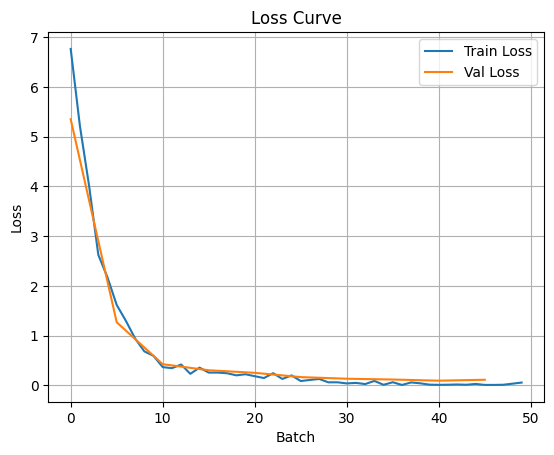

In [33]:
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()
train(train_cfg, vlm_cfg)

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it